In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
savename='XTime_LES3vsDRY3'

In [3]:
# Global path = "/global/scratch/users/adac/Slope_Flow/SlopeFlow/WRFV3/LES3/"
# Template file = "wrfout_d01_2014-03-21_12:00:00"

paths = ["../WRFV3/LES3_sunset", "../WRFV3/DRY3_sunset"]
file= "wrfout_d01_2014-03-21_17:30:00"

L1 = 3e3
L2 = 1e3

slope1 = 3*np.pi/180.
slope2 = 5*np.pi/180.

ds = xr.open_dataset(paths[0]+'/'+file)#+'.nc')
ds

<xarray.Dataset>
Dimensions:                (Time: 61, south_north: 149, west_east: 399,
                            bottom_top: 68, bottom_top_stag: 69,
                            soil_layers_stag: 4, west_east_stag: 400,
                            south_north_stag: 150)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/153)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/119)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2014-03-21_17:30:00
    SIMULATION_START_DATE:           2014-03-21_12:00:00
    WEST-EAST_GRID_DIMENSION:        400
    SOUTH-NORTH_GRID_DIMENSION:      150
    BOTTOM-TOP_GRID_DIMENSION:       69
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      -1
    ETAC:                            0.0

In [4]:
# ds = xr.open_dataset(paths[1]+'/'+file)#+'.nc')
# ds

In [5]:
times = ds['Times']
nt = len(times)
dt = 0.5/60 # 30 s/60(s/min)/60(min/hr) = dt [hrs] 
tv = np.arange(0,nt*dt,dt).T + 17.5 # starts 17:30

In [6]:
#nz = ds.dims["bottom_top"]
#ny = ds.dims["south_north"]
nx = ds.dims["west_east_stag"]
ixstart = nx//2 #+ 1 to start on slope not peak
dx = ds.attrs['DX']
ixend = nx//2 + int( (L1+L2) / dx ) #(L2 = 1km + L1 = 3)dx
xmid = (nx-1)/2*dx
xmid

9975.0

In [7]:
xv = np.arange(dx/2,nx*dx,dx) - xmid
x = np.tile(xv, (nt,1))
x.shape

(61, 400)

In [8]:
t = np.tile(tv, (nx,1)).T
t.shape

(61, 400)

In [9]:
t_shadow = np.empty( nx )
iL2end = nx//2+int( L2/dx )

t_shadow[ixstart:iL2end] = 18 - 12/np.pi*slope2
t_shadow[iL2end:ixend] = 18 - 12/np.pi*np.arctan( np.tan(slope1) + L2 / xv[iL2end:ixend] * (np.tan(slope2) - np.tan(slope1)) )

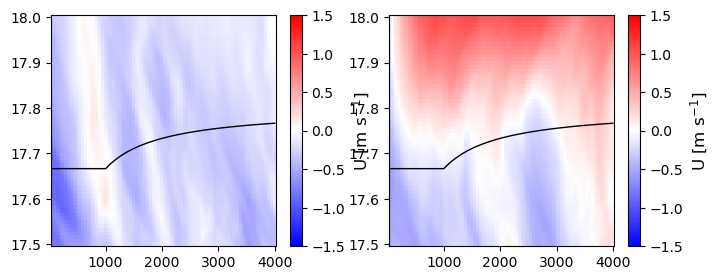

In [10]:
try:
    del(fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots( 1, 2, figsize=(8, 3) )
except:
    fig, axs = plt.subplots( 1, 2, figsize=(8, 3) )
    
cbarLabels = [r'U [m s$^{-1}$]']

vmin = -1.5
vmax = 1.5

for i,path in enumerate(paths):
    ds = xr.open_dataset(path+'/'+file)#+'.nc')
    u = ds['U'][:,0].mean(dim=["south_north"])

    cf2 = axs[i].pcolor( x[:,ixstart:ixend], t[:,ixstart:ixend],u[:,ixstart:ixend].values, cmap="bwr", vmin=vmin, vmax=vmax)

    shd = axs[i].plot(xv[ixstart:ixend], t_shadow[ixstart:ixend], 'k', linewidth=1)

    cb = plt.colorbar(
        cf2,
        ax=axs[i],
        norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),
        cmap="bwr")
    


In [11]:
for i,ax in enumerate(axs):
    ax.set_xlabel(r'$x-x_{\text{mid}}$ [m]',size=12)
    ax.set_yticks([17.5, 17.+40./60. , 17.+50./60. , 18])
    ax.set_yticklabels(['17:30', '17:40', '17:50', '18:00'], size=12)
    ax.set_title(paths[i][-11:-7])
   
fig.tight_layout()

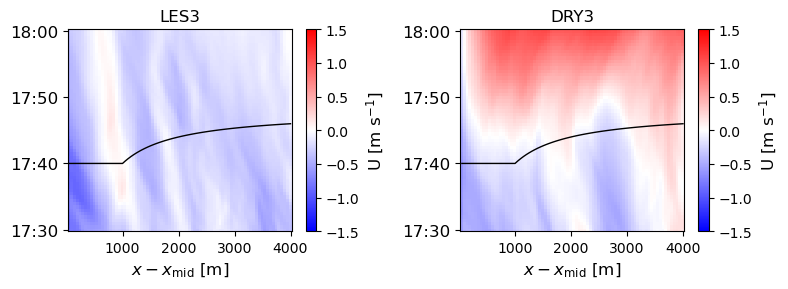

In [12]:
fig

In [13]:
save=True
if save:
    plt.figure(fig)
    fmts=["png","eps"]
    for fmt in fmts:
        plt.savefig("plots/"+savename+"."+fmt, format=fmt)